In [166]:
from pprint import pprint
from xml.etree import ElementTree
from tyssue import Sheet, PlanarGeometry, config
from tyssue.draw import sheet_view


import pandas as pd

In [217]:
def granar_xml_parser(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()

    metadata = {p.get('name'): p.get("value") for p in 
                root.find("metadata").find('parameters').findall("parameter")}
    pprint(metadata)
    faces = root.find('cells').findall('cell')
    edges = root.find('walls').findall('wall')

    face_df = pd.DataFrame(index=pd.RangeIndex(len(faces), name="face"), columns=['x', 'y', 'group'])
    edge_df = pd.DataFrame(index=pd.RangeIndex(len(edges), name="edge"),
                           columns=['srce', 'trgt', 'face', 'sx', 'sy', 'tx', 'ty'])


    for e, edge in enumerate(edges):
        srce, trgt = edge.find('points').findall('point')
        for c in 'xy':
            edge_df.loc[e, "s"+c] = float(srce.get(c))
            edge_df.loc[e, "t"+c] = float(trgt.get(c))

    print(edge_df.head())

    for f, face in enumerate(faces):
        face_edges = [int(w.get("id")) for w in 
                      face.find('walls').findall("wall")]
        edge_df.loc[face_edges, 'face'] = f
        face_df.loc[f, 'group'] = int(face.get('group'))

    edge_df['face'] = edge_df['face'].astype(int)

    vert_df = edge_df.groupby(['sx', 'sy']).first().reset_index()[['sx', 'sy']]
    vert_df.columns = ['x', 'y']
    vert_df.index.name = 'vert'

    for v, (x, y) in vert_df.iterrows():
        edge_df.loc[(edge_df.sx==x) & (edge_df.sy==y), 'srce'] = v
        edge_df.loc[(edge_df.tx==x) & (edge_df.ty==y), 'trgt'] = v


    datasets = {'edge': edge_df, 'face': face_df, 'vert': vert_df}
    sheet = Sheet('granar', datasets.copy(), config.geometry.planar_sheet())

    sheet.remove(sheet.edge_df[pd.isna(sheet.edge_df['trgt'])].index)

    sheet.reset_index()
    sheet.reset_topo()
    sheet.settings.update(metadata)
    PlanarGeometry.update_all(sheet)
    reved = sheet.edge_df.query('sub_area < 0').index


    sheet.edge_df.loc[reved, ['srce', 'trgt']] = sheet.edge_df.loc[reved, ['trgt', 'srce']]
    sheet.reset_index()
    sheet.reset_topo()
    PlanarGeometry.update_all(sheet)
    
    return sheet


In [218]:
sheet = granar_xml_parser("crosssection.xml")

{'aerenchyma': '0',
 'all': '0.420979118162631',
 'companion_cell': '0.00011712342570756',
 'cortex': '0.000890932933516369',
 'endodermis': '0.000546246215062463',
 'epidermis': '0.000168364856757967',
 'exodermis': '0.000698079091328178',
 'pericycle': '0.000178738204114402',
 'phloem': '0.00011991909555605',
 'planttype': '1',
 'randomness': '3',
 'simulation': '2.06555795669556',
 'stele': '0.000117006382141473',
 'xylem': '0.000731411465290372'}
     srce trgt face        sx        sy        tx        ty
edge                                                       
0     NaN  NaN  NaN  0.381921  0.374071  0.377162  0.377899
1     NaN  NaN  NaN   0.38868  0.373709  0.381921  0.374071
2     NaN  NaN  NaN  0.392042  0.377128   0.38868  0.373709
3     NaN  NaN  NaN  0.392042  0.377128  0.390624  0.383666
4     NaN  NaN  NaN  0.390624  0.383666  0.382351  0.389005


In [220]:
sheet.sanitize()

ValueError: sanitize would delete the whole epithlium

> /home/guillaume/miniconda3/lib/python3.7/site-packages/tyssue-0.3.3-py3.7-linux-x86_64.egg/tyssue/core/objects.py(633)remove()
    631             return
    632         if fto_rm.shape[0] == self.datasets[top_level].shape[0]:
--> 633             raise ValueError("sanitize would delete the whole epithlium")
    634 
    635         fto_rm.sort()

ipdb> x
*** NameError: name 'x' is not defined
ipdb> c


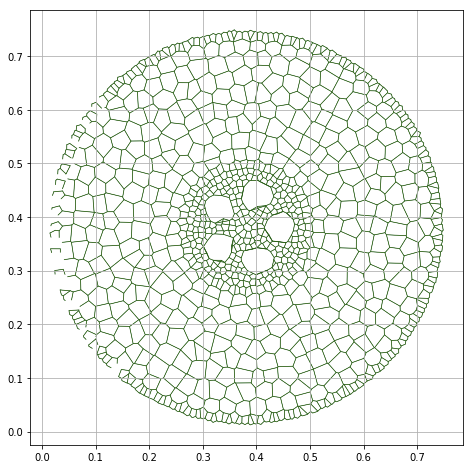

In [216]:
fig, ax = sheet_view(sheet, mode="2D",
                     edge={"head_width": 0.0},
                     vert={"visible": False},
                     face={"visible": False, "color": sheet.face_df['area']})
fig.set_size_inches(8, 8)

In [195]:
%pdb

Automatic pdb calling has been turned ON


In [206]:
print(edge_df.head())
from tyssue.core.objects import _ordered_edges

      srce  trgt  face        sx        sy        tx        ty   nz  length  \
edge                                                                          
0     1026  1007     6  0.381921  0.374071  0.377162  0.377899  1.0     1.0   
1     1058  1026     7   0.38868  0.373709  0.381921  0.374071  1.0     1.0   
2     1071  1058     8  0.392042  0.377128   0.38868  0.373709  1.0     1.0   
3     1071  1067     9  0.392042  0.377128  0.390624  0.383666  1.0     1.0   
4     1067  1030     1  0.390624  0.383666  0.382351  0.389005  1.0     1.0   

       dx   dy   fx   fy  
edge                      
0     0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  
